In [109]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import cv2 as cv
from shapely import geometry

In [69]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 14
LR = 0.001
LOG_INTERVAL = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [70]:
# class MNIST(datasets.MNIST):
    
#     def __init__(self, path, train=True, download=False, transform=None):
#         super().__init__(root=path, train=train, download=download, transform=transform)
        
    
#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.targets[index]
#         return x, y
    
#     def __len__(self):
#         return(len(self.data))


###############################
# !!! You don't need this !!! #
###############################

In [71]:
# def img_to_poly(data):
#     data = data.view(-1, 784)
#     data = list(data.unbind())
#     data = [torch.arange(784)[(x > 0.8)] for x in data]
#     data = [torch.Tensor(list(x) + (351 - len(x)) * [0]) for x in data]
#     data = torch.stack(data).contiguous()
#     return torch.reshape(data, (len(data) , 1, 351))

# transform=transforms.Compose([
#     transforms.Lambda(lambda x: img_to_poly(x))
# ]) 


###################################################
# !!! Let's write it as a class (encapsulate) !!! #
# it can also by modified. but not now            #
# if you do not understand why I                  #
# use here __call__, read about callable objects  #
# in python                                       #
###################################################
class TensorToPolygon:
    
    
    def __call__(self, data):
        data = data.view(-1, 784)
        data = list(data.unbind())
        data = [torch.arange(784)[(x > 0.8)] for x in data]
        data = [torch.Tensor(list(x) + (351 - len(x)) * [0]) for x in data]
        data = torch.stack(data).contiguous()
        return torch.reshape(data, (len(data) , 351))

In [72]:
# dataset1 = MNIST('~/Developer/datasets', train=True, transform=transform)
# dataset2 = MNIST('~/Developer/datasets', train=False, transform=transform)
dataset1 = datasets.MNIST('~/Developer/datasets', train=True, 
                          transform=transforms.Compose([
                              #transforms.RandomCrop(28, padding=2), # random shift by +- 2 pixels in all direcitons
                              transforms.RandomAffine(degrees=180, translate=(0,0.2), scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon()
                          ]))
dataset2 = datasets.MNIST('~/Developer/datasets', train=False, 
                          transform=transforms.Compose([
                              transforms.RandomAffine(degrees=180, translate=(0,0.2), scale=None),
                              transforms.ToTensor(),
                              TensorToPolygon()
                          ]))
# here the train dataset is with shifts
# let's first check whether it helps to improve the performance on the original test subset

In [62]:
# Do not forget to shuffle the training subset
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=TEST_BATCH_SIZE, shuffle=False)

torch.Size([64, 1, 351])


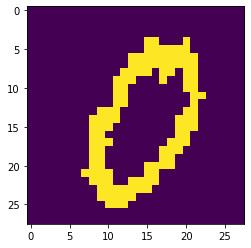

In [81]:
print(next(iter(train_loader))[0].shape)

matrix = np.zeros(28*28)

for a in next(iter(train_loader))[0][0][0]:
    if a == 0:
        break
    np.put(matrix, a, 1)

matrix = np.reshape(matrix, (28,28))
plt.imshow(matrix)

{'m00': 113.0, 'm10': 1657.1666666666665, 'm01': 1665.1666666666665, 'm20': 25195.0, 'm11': 23739.916666666664, 'm02': 26269.333333333332, 'm30': 395923.65, 'm21': 351261.6333333333, 'm12': 364849.1333333333, 'm03': 438644.65, 'mu20': 892.3330875122956, 'mu11': -680.0717797443431, 'mu02': 1731.4569813176058, 'mu30': 261.67245092999656, 'mu21': -64.82328614153812, 'mu12': -352.6174490882913, 'mu03': 510.60466958454344, 'nu20': 0.06988276979499534, 'nu11': -0.05325959587628969, 'nu02': 0.13559847923232876, 'nu30': 0.0019277996340428428, 'nu21': -0.0004775676876070651, 'nu12': -0.0025978118326693265, 'nu03': 0.0037617391195261295}


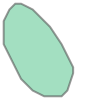

In [130]:
ret,thresh = cv.threshold(matrix,0.99,1,cv.THRESH_BINARY)
thresh = thresh.astype(np.uint8)
contours, hierarchy = cv.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv.moments(cnt)
print(M)

cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

area = cv.contourArea(cnt)

perimeter = cv.arcLength(cnt,True)

epsilon = 0.01*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)
geometry.Polygon(np.reshape(approx,(approx.shape[0],2)))

hull = cv.convexHull(cnt)
geometry.Polygon(np.reshape(hull,(hull.shape[0],2)))

In [64]:
class SimpleModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(351, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 256, bias=False), 
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 10),
            nn.Softmax(1)
        )
        
    def forward(self, x):
        return self.net(x[:, 0])

In [65]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end="\r")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [66]:
model = SimpleModel().to(DEVICE)
#summary(model, (1, 351))
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [59520/60000 (99%)]	Loss: 2.201674
Test set: Average loss: 2.1840, Accuracy: 2620/10000 (26.2%)

Train Epoch: 2 [59520/60000 (99%)]	Loss: 2.235529
Test set: Average loss: 2.1764, Accuracy: 2724/10000 (27.2%)

Train Epoch: 3 [59520/60000 (99%)]	Loss: 2.136459
Test set: Average loss: 2.1543, Accuracy: 3021/10000 (30.2%)

Train Epoch: 4 [59520/60000 (99%)]	Loss: 2.128374
Test set: Average loss: 2.1575, Accuracy: 2959/10000 (29.6%)

Train Epoch: 5 [59520/60000 (99%)]	Loss: 2.119542
Test set: Average loss: 2.1432, Accuracy: 3118/10000 (31.2%)

Train Epoch: 6 [59520/60000 (99%)]	Loss: 2.092604
Test set: Average loss: 2.1416, Accuracy: 3128/10000 (31.3%)

Train Epoch: 7 [59520/60000 (99%)]	Loss: 2.056538
Test set: Average loss: 2.1331, Accuracy: 3234/10000 (32.3%)

Train Epoch: 8 [59520/60000 (99%)]	Loss: 2.073303
Test set: Average loss: 2.1338, Accuracy: 3214/10000 (32.1%)

Train Epoch: 9 [59520/60000 (99%)]	Loss: 2.162591
Test set: Average loss: 2.1311, Accuracy: 3207/10000 (

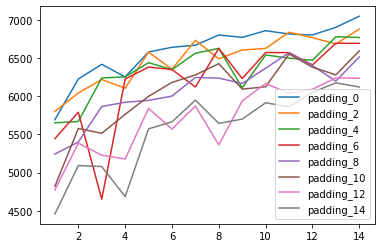

In [160]:
results_list_backup = results_list[16:-14]


df = pd.DataFrame(results_list_backup)
df = df.rename(columns = {0:'correct', 1:'amount', 2:'shift'})

#shifts = list(set(df['shift']))
shifts = [0,2,4,6,8,10,12,14]

new_df = pd.DataFrame({'amount':[10000]*14})

for a in shifts:
    new_df[str('padding_' + str(a))] = list(df['correct'][df['shift'] == a])
new_df['epoch'] = list(range(1,15))
new_df

for columnname, columnData in new_df.iteritems():
    if columnname.startswith('padding'):
        plt.plot('epoch', columnname, data=new_df)
plt.legend()
plt.show()


In [161]:
results_list_backup

[[5694, 10000, 0],
 [6226, 10000, 0],
 [6418, 10000, 0],
 [6253, 10000, 0],
 [6579, 10000, 0],
 [6641, 10000, 0],
 [6668, 10000, 0],
 [6802, 10000, 0],
 [6770, 10000, 0],
 [6858, 10000, 0],
 [6814, 10000, 0],
 [6802, 10000, 0],
 [6902, 10000, 0],
 [7047, 10000, 0],
 [5518, 10000, 1],
 [6077, 10000, 1],
 [6186, 10000, 1],
 [6187, 10000, 1],
 [6447, 10000, 1],
 [6681, 10000, 1],
 [6476, 10000, 1],
 [6779, 10000, 1],
 [6513, 10000, 1],
 [6739, 10000, 1],
 [6885, 10000, 1],
 [6879, 10000, 1],
 [6985, 10000, 1],
 [7005, 10000, 1],
 [5801, 10000, 2],
 [6043, 10000, 2],
 [6219, 10000, 2],
 [6105, 10000, 2],
 [6578, 10000, 2],
 [6353, 10000, 2],
 [6732, 10000, 2],
 [6490, 10000, 2],
 [6605, 10000, 2],
 [6626, 10000, 2],
 [6838, 10000, 2],
 [6766, 10000, 2],
 [6684, 10000, 2],
 [6879, 10000, 2],
 [5250, 10000, 3],
 [5977, 10000, 3],
 [5952, 10000, 3],
 [6084, 10000, 3],
 [6449, 10000, 3],
 [6383, 10000, 3],
 [6497, 10000, 3],
 [6373, 10000, 3],
 [6584, 10000, 3],
 [6582, 10000, 3],
 [6703, 1000

In [96]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )
        
        
#         self.conv1 = nn.Conv2d(1, 32, 3, 1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(9216, 128)
#         self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         x = self.fc2(x)


        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.linear(x)
#         output = F.log_softmax(x, dim=1)
#         return output

In [100]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end="\r")


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [102]:
model = Net().to(DEVICE)
#summary(model, (1, 351))
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

torch.save(model.state_dict(), "mnist_cnn.pt")

RuntimeError: Calculated padded input size per channel: (1 x 351). Kernel size: (3 x 3). Kernel size can't be greater than actual input size